In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, assemble, execute
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.gate import Gate
from qiskit.circuit.quantumregister import Qubit

import numpy as np
import math
import matplotlib.pyplot as plt
import sys
import random

aer_sim = Aer.get_backend('aer_simulator')
simulator = QasmSimulator()
shots = 10

"""
Propiedades metamorficas B-V:

MT1: Si aplicamos el algoritmo a f_s y f_s1 por separado, donde s1 es el complementario binario de s,
        y luego sumamos ambos resultados, nos debería dar el ket |1> de dimension len(s).
        
MT2: Si aplicamos el algoritmo a f_s y f_s1 por separado, la suma de ambos resultados, nos debería dar s+s1.

MT3: Si aplicamos al algoritmo a ambas funciones sucesivamente, f_s y f_s1, nos devuelve la suma bit a bit de s y s1.
"""

def sMT_generator(rule,n): #Genera aleatoriamente las cadenas s, para las distintas reglas.
    s = ''
    s1 = ''
    if rule==1:
        for i in range(n):
            k=random.randint(0,1)
            s+=str(k)
            if k==0:
                s1+='1'
            else:
                s1+='0'
    else:
        for i in range(n):
            k=random.randint(0,1)
            s+=str(k)
            k=random.randint(0,1)
            s1+=str(k)
    return s, s1

def bv_fgenerator(n,s): #Genera la puerta f_s/f_s1 para las distintas reglas.      
    qc=QuantumCircuit(n+1)
    s = s[::-1]
    for q in range(n):
        if s[q] == '0':
            qc.i(q)
        else:
            qc.cx(q, n)
    return qc
            
def sum_bit_to_bit_gate(n): #n=len(s)
    qubits=3*n+2
    qc = QuantumCircuit(qubits)
    for i in range(n):
        qc.cx(n-i-1,qubits-i-1)
        qc.cx(2*n-i,qubits-i-1)
    return qc

def bv_testSetUp(rule,qc,n): #Añade al circuito las puertas necesarias respecto a las reglas y mide.
    if rule==3:
        for i in range(n):
            qc.measure(i, i)
    else:
        suma=sum_bit_to_bit_gate(n)
        sgate = suma.to_gate(label='  suma  \n bit to bit')
        qc.append(sgate, range(3*n+2))
        for i in range(n):
            qc.measure(2*(n+1)+i, i)
            
def bv_MT(rule,n):
    s,s1=sMT_generator(rule,n)
    print("s es:", s)
    print("s1 es:", s1)
    nameS='  f_s  \n \ns='+s
    nameS1='  f_s1  \n \ns1='+s1
    
    f=bv_fgenerator(n,s)
    f_s= f.to_gate(label=nameS)
    
    f1=bv_fgenerator(n,s1)
    f_s1= f1.to_gate(label=nameS1)
    
    if rule==3:
        qs=QuantumRegister(n, 's')
        anc1=QuantumRegister(1, 'anc1')
        c_test=ClassicalRegister(n, 'c_test')
        qc = QuantumCircuit(qs, anc1, c_test)
    
        for i in range(n+1):
            qc.h(i)
        qc.z(n)
        
        qc.barrier()
        qc.append(f_s, range(n+1))
        qc.barrier()
        qc.append(f_s1, range(n+1))
    
        qc.barrier()
        for i in range(n):
            qc.h(i)
        qc.barrier()
        
    else:
        qs=QuantumRegister(n, 's')
        anc1=QuantumRegister(1, 'anc1')
        qs1=QuantumRegister(n, 's1')
        anc2=QuantumRegister(1, 'anc2')
        q_test=QuantumRegister(n, 'q_test')
        c_test=ClassicalRegister(n, 'c_test')
        qc = QuantumCircuit(qs, anc1, qs1, anc2, q_test, c_test)
    
        for i in range(2*(n+1)):
            qc.h(i)
        qc.z(n)
        qc.z(2*n+1)
    
        qc.barrier()
    
        qc.append(f_s, range(n+1))
        qc.append(f_s1, range(n+1,2*n+2))
    
        qc.barrier()
        for i in range(n):
            qc.h(i)
        
        for i in range(n+1,2*n+1):
            qc.h(i)
        qc.barrier()
        
    bv_testSetUp(rule,qc,n)
    
    return qc

s es: 011
s1 es: 100


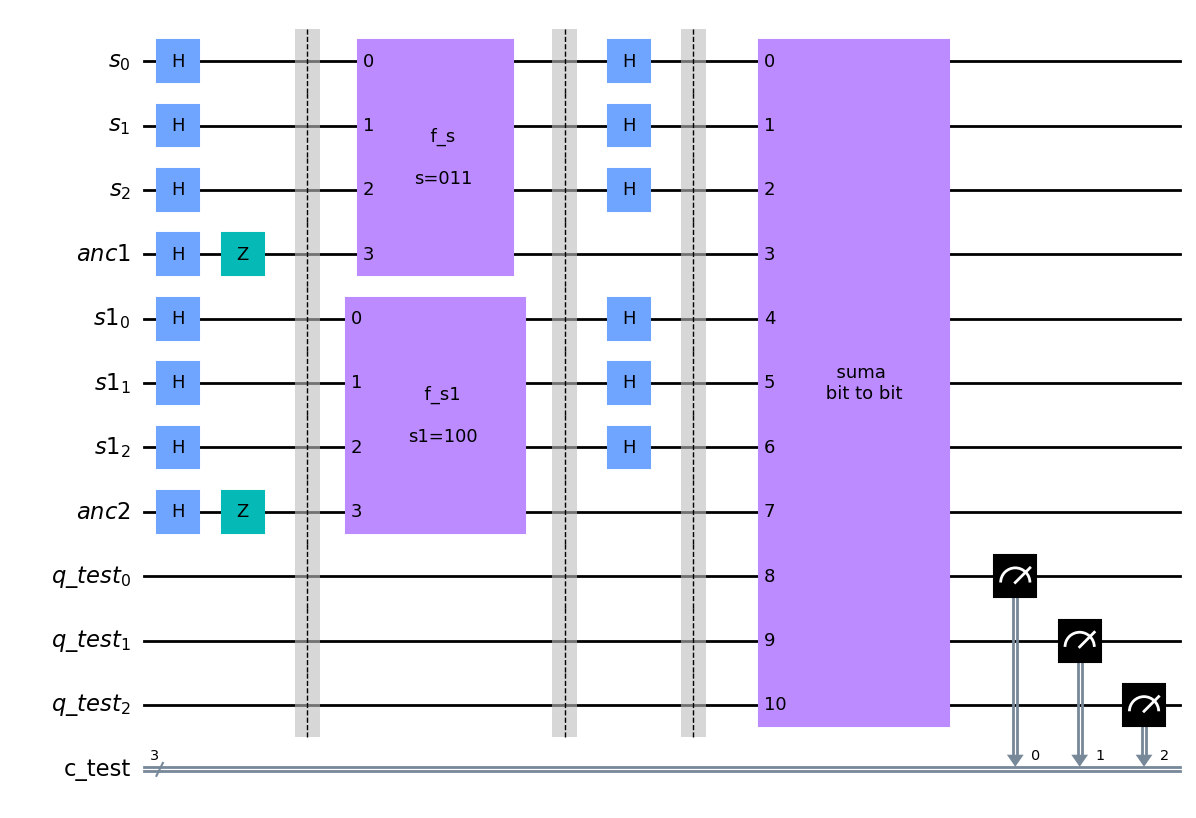

In [2]:
test1=bv_MT(1,3)
test1.draw(output='mpl')

s es: 001
s1 es: 110


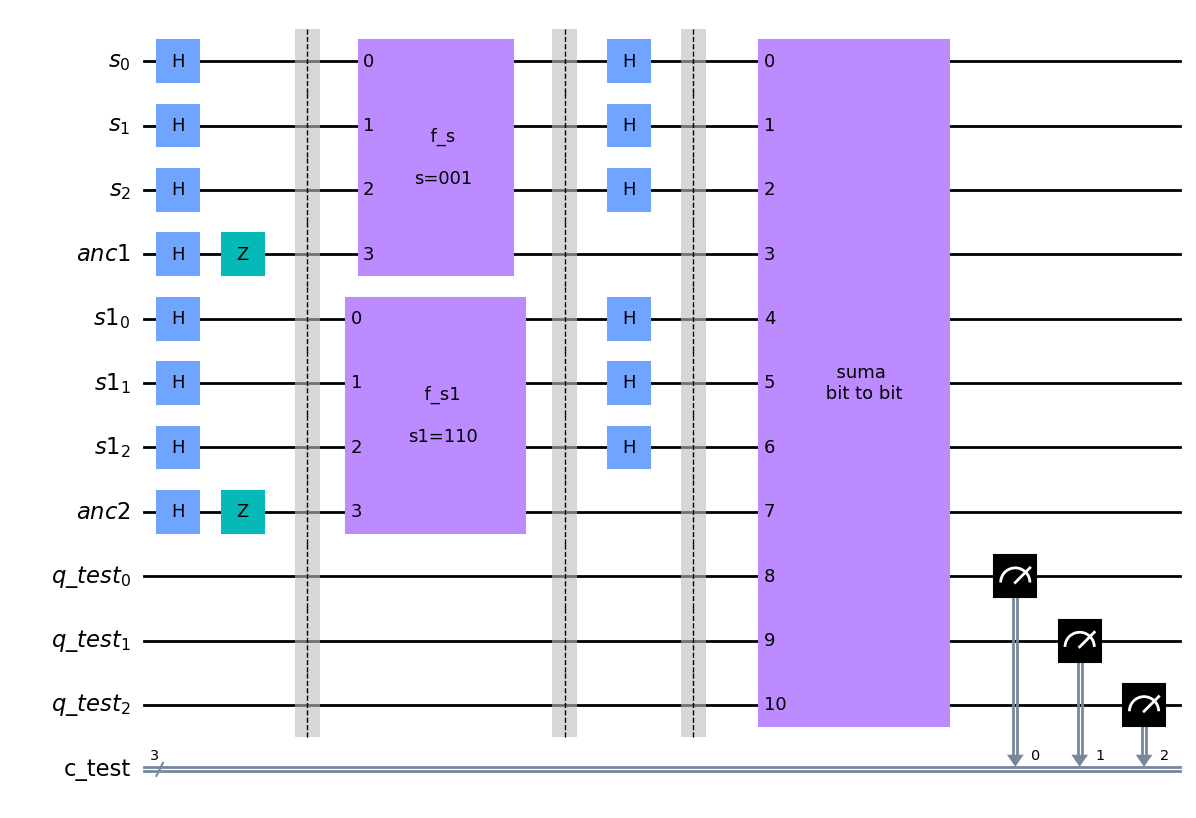

In [3]:
test2=bv_MT(2,3)
test2.draw(output='mpl')

s es: 001
s1 es: 101


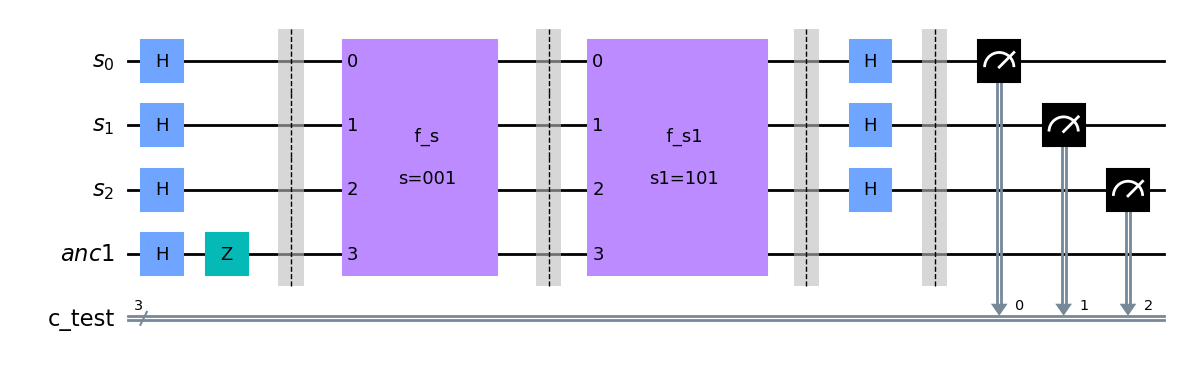

In [4]:
test3=bv_MT(3,3)
test3.draw(output='mpl')

In [5]:
qobj = assemble(test3)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-107 contains invalid instructions {"gates": {circuit-104, circuit-101}} for "statevector" method.


QiskitError: 'ERROR:  [Experiment 0] Circuit circuit-107 contains invalid instructions {"gates": {circuit-104, circuit-101}} for "statevector" method. ,  ERROR: Circuit circuit-107 contains invalid instructions {"gates": {circuit-104, circuit-101}} for "statevector" method.'